In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import json
import scipy.stats as stats
from urllib import request
from urllib.error import HTTPError
from multiprocessing import Pool

df = pd.read_parquet("../kaggle-pog-series-s01e01/train.parquet")

In [2]:
df["description"] = df["description"].fillna("")
df = df.dropna()
df.isna().sum()

video_id             0
title                0
publishedAt          0
channelId            0
channelTitle         0
categoryId           0
trending_date        0
tags                 0
view_count           0
likes                0
dislikes             0
comment_count        0
thumbnail_link       0
comments_disabled    0
ratings_disabled     0
description          0
id                   0
duration_seconds     0
has_thumbnail        0
target               0
dtype: int64

In [3]:
df.dtypes

video_id                          object
title                             object
publishedAt          datetime64[ns, UTC]
channelId                         object
channelTitle                      object
categoryId                         int64
trending_date             datetime64[ns]
tags                              object
view_count                         int64
likes                              int64
dislikes                           int64
comment_count                      int64
thumbnail_link                    object
comments_disabled                   bool
ratings_disabled                    bool
description                       object
id                                object
duration_seconds                 float64
has_thumbnail                       bool
target                           float64
dtype: object

# video_id

In [4]:
df["video_id"].duplicated().value_counts()

True     73569
False    16530
Name: video_id, dtype: int64

In [5]:
df = df.drop_duplicates("video_id")

In [6]:
df["video_id"].duplicated().value_counts()

False    16530
Name: video_id, dtype: int64

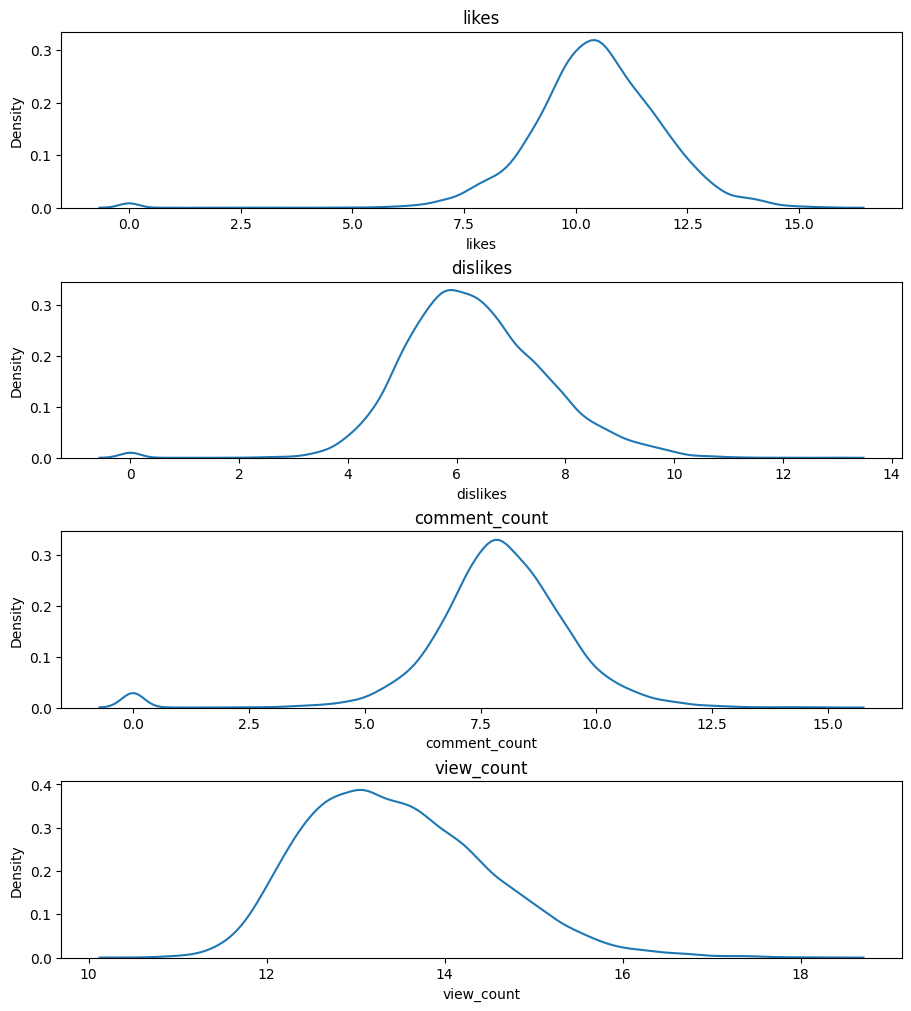

In [7]:
titles = ["likes", "dislikes", "comment_count", "view_count"]

eps = 1
df[titles] = np.log(df[titles] + eps)

fig, axes = plt.subplots(nrows=4, ncols=1, constrained_layout=True, figsize=(9, 10))


for i, title in enumerate(titles):
    axes[i].title.set_text(title)
    sns.kdeplot(df[title], ax=axes[i])
plt.show()

In [8]:
df["trending_date"] = pd.to_datetime(df["trending_date"])
df["publish_day"] = df["publishedAt"].dt.weekday

one_hot = pd.get_dummies(df["publish_day"], prefix="publish_day")
df = df.drop(columns=["publish_day"])
df = df.join(one_hot)

In [9]:
df["trending_date-publishedAt"] = df["trending_date"].dt.date - df["publishedAt"].dt.date
df["trending_date-publishedAt"] = df["trending_date-publishedAt"] / np.timedelta64(1, 'D')

In [10]:
one_hot = pd.get_dummies(df["categoryId"], prefix="categoryId")
df = df.drop(columns=["categoryId"])
df = df.join(one_hot)

In [11]:
df["tags_len"] = df["tags"].apply(lambda x : len(x.split("|")) if x != "[none]" else 0)
df["description_len"] = df["description"].apply(lambda x : len(x))


계속 스트리밍 되는 영상 때문에 이상치가 있는 듯

In [12]:
def split_outlier(df, fator=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    outlier_index = ((df < (Q1 - fator * IQR)) |(df > (Q3 + fator * IQR))).any(axis=1)
    return df[~outlier_index]

In [13]:
df[["duration_seconds"]] = split_outlier(df[["duration_seconds"]], 3)

df = df.dropna()

In [14]:
df["has_thumbnail"] = True

In [15]:
Q1 = df["description_len"].quantile(0.25)
Q3 = df["description_len"].quantile(0.75)
IQR = Q3 - Q1

df["description_title"] = df["title"].str.cat(df["description"].str[:int(Q3 + 1.5 * IQR)])
df["description_title"]

40       Shannon reacts to Kyle Kuzma's game-winning sh...
41       Answering Your Assumptions About Us... Merrell...
42       Unboxing Apple's $129 Luxury CableShhhhFOLLOW ...
43       Giannis Gets Ejected After Headbutting Mo Wagn...
44       I TOOK A PREGNANCY TEST...▷SUBSCRIBE FOR DAILY...
                               ...                        
92132    POST FIGHT Kambosos: Teofimo DELUSIONAL, Lopez...
92134    Tom Brady on Comeback Win Over the Colts | Pre...
92143    Maxwell Celebrates Living Legend Award With Pe...
92154    Huge Stealth Change in Warzone After 18 Months...
92165    13 AGAIN 🎂❗️❗️ ❗️ | Ep.1 Kinigra Turned 13 Aga...
Name: description_title, Length: 16229, dtype: object

In [16]:
import shutil
import os
    
source_dir = './thumbnails'
target_dir = '../kaggle-pog-series-s01e01/thumbnails'
    
file_names = os.listdir(source_dir)
    
for file_name in file_names:
    if not os.path.exists(os.path.join(target_dir, file_name)):
        shutil.move(os.path.join(source_dir, file_name), target_dir)
    
df.to_parquet("../kaggle-pog-series-s01e01/dataset_fe.parquet")